# Imports

In [78]:
import numpy as np

In [79]:
from collections import Counter

In [80]:
from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import r2_score as sk_r2_score

from sklearn.preprocessing import StandardScaler

In [81]:
import matplotlib.pyplot as plt

# Funcs and classes

## Funcs

In [82]:
def mean_squared_error(y_true, y_pred):
    len_y = len(y_pred)
    return 1 / len_y * sum(y_true - y_pred) ** 2


def r2_score(y_true, y_pred):
    ssr = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - y_true.mean()) ** 2)
    
    if sst == 0:
        return 0.0

    return 1 - ssr / sst

## Classes

In [83]:
class SelfLinearRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000, metric_fn=mean_squared_error):
        """
        Своя реализация линейной регрессии
        """
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
        self.metric_fn = metric_fn
        self.metric_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            y_pred = self.predict(X)

            loss = self.metric_fn(y, y_pred)
            self.metric_history.append(loss)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [84]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class DecisionTree:

    def __init__(self, max_depth=10, min_samples_split=2, criterion="entropy", random_state=42):
        """
        Своя реализация дерева решений
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.root = None

    def _entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def _information_gain(self, X, y, feature, threshold):
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
            return 0

        parent_entropy = self._entropy(y)

        n = len(y)
        n_left, n_right = len(y[left_mask]), len(y[right_mask])
        entropy_left = self._entropy(y[left_mask])
        entropy_right = self._entropy(y[right_mask])

        ig = parent_entropy - (n_left / n * entropy_left + n_right / n * entropy_right)
        return ig

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        n_features = X.shape[1]

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape

        if (
            depth >= self.max_depth
            or n_samples < self.min_samples_split
            or len(np.unique(y)) == 1
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feature, threshold = self._best_split(X, y)

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left, right=right)

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

## Data loading

### Classification

In [85]:
iris = load_iris()
X_class, y_class = iris.data, iris.target

X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

### Regression

In [86]:
diabetes = load_diabetes()
X_reg, y_reg = diabetes.data, diabetes.target


X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [87]:
scaler = StandardScaler()

X_reg_train = scaler.fit_transform(X_reg_train)
X_reg_test = scaler.transform(X_reg_test)

# Testing

По заданию необходимо провести исследование.

Для этого я решил сравнить собственную релизацию и реализацию из `sklearn`.

In [88]:
def check_score(test, pred, func, title_func, title_method, silent=False, **kwargs):
    if kwargs.get("average"):
        result = func(test, pred, average=kwargs["average"])
    else:
        result = func(test, pred)

    if silent:
        return result

    print(f"{title_method}\t{title_func}:\t{result:.4f}")
    return result

In [89]:
format_str = "=" * 3 + " " + "{}" + " " + "=" * 3 + "\n" + "-" * 10

## Classification

In [90]:
max_depth = 3
print(format_str.format("ДЕРЕВО РЕШЕНИЙ"))

for tree_name, tree_type in zip(
    ["Своя", "Sklearn decision", "Sklearn extra"],
    [DecisionTree, DecisionTreeClassifier, ExtraTreeClassifier],
):
    for metric_name, metric, kwargs in zip(
        ["accuracy", "precision"],
        [accuracy_score, precision_score],
        [{}, {"average": "macro"}],
    ):
        tree = tree_type(max_depth=max_depth, random_state=42)
        tree.fit(X_class_train, y_class_train)
        tree_pred = tree.predict(X_class_test)
        score = check_score(
            y_class_test, tree_pred, metric, metric_name, tree_name, False, **kwargs
        )
    print("-" * 10)

=== ДЕРЕВО РЕШЕНИЙ ===
----------
Своя	accuracy:	0.9667
Своя	precision:	0.9722
----------
Sklearn decision	accuracy:	1.0000
Sklearn decision	precision:	1.0000
----------
Sklearn extra	accuracy:	1.0000
Sklearn extra	precision:	1.0000
----------


In [91]:
# Исследование влияния глубины дерева на точность
metrics_name_list = ["accuracy", "precision"]
depths = range(1, 11)
self_metrics = {metric: [] for metric in metrics_name_list}
sklearn_metrics = {metric: [] for metric in metrics_name_list}
sklearn_extra_metrics = {metric: [] for metric in metrics_name_list}

for depth in depths:
    for tree_type, metrics_list in zip(
        [DecisionTree, DecisionTreeClassifier, ExtraTreeClassifier],
        [self_metrics, sklearn_metrics, sklearn_extra_metrics],
    ):
        for metric_name, metric, kwargs in zip(
            ["accuracy", "precision"],
            [accuracy_score, precision_score],
            [{}, {"average": "macro"}],
        ):
            tree = tree_type(max_depth=depth, random_state=42)
            tree.fit(X_class_train, y_class_train)
            tree_pred = tree.predict(X_class_test)
            score = check_score(
                y_class_test, tree_pred, metric, None, None, True, **kwargs
            )
            metrics_list[metric_name].append(score)

d:\PyVenv\Neural\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\PyVenv\Neural\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\PyVenv\Neural\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [92]:
def plot_classification(index_tuples, zip_scores_labels, metric_name):
    plt.subplot(*index_tuples)
    for score, label in zip_scores_labels:
        plt.plot(depths, score, "o-", label=label)
    plt.xlabel("Глубина дерева")
    plt.ylabel(metric_name)
    plt.title(f"Влияние глубины дерева на {metric_name}")
    plt.legend()
    plt.grid(True)

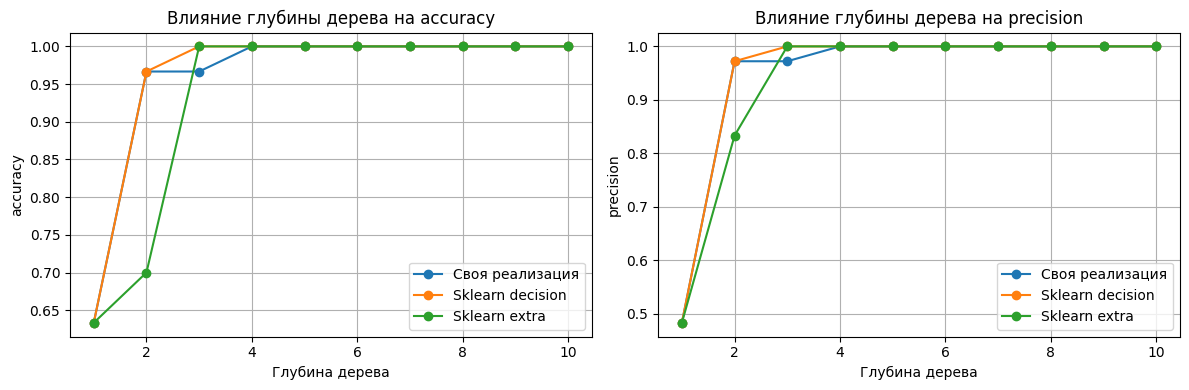

In [93]:
plt.figure(figsize=(12, 4))

for idx, metric_name in enumerate(metrics_name_list):
    plot_classification(
        (1, len(metrics_name_list), idx + 1),
        zip(
            [
                self_metrics[metric_name],
                sklearn_metrics[metric_name],
                sklearn_extra_metrics[metric_name],
            ],
            [
                "Своя реализация",
                "Sklearn decision",
                "Sklearn extra",
            ],
        ),
        metric_name,
    )

plt.tight_layout()
plt.show()

## Regression

In [94]:
print(format_str.format("ЛИНЕЙНАЯ РЕГРЕССИЯ"))


reg_metrics_name_list = ["MSE", "r2 score"]
reg_models_names = ["Своя", "Sklearn", "xgboost"]
reg_models = {
    metric: {model_type: None for model_type in reg_models_names}
    for metric in reg_metrics_name_list
}

reg_predictions = {metric: np.inf for metric in reg_metrics_name_list}
reg_sk_predictions = {metric: np.inf for metric in reg_metrics_name_list}
reg_sk_log_predictions = {metric: np.inf for metric in reg_metrics_name_list}

for reg_name, reg_type, reg_preds in zip(
    reg_models_names,
    [SelfLinearRegression, SklearnLinearRegression, XGBRegressor],
    [reg_predictions, reg_sk_predictions, reg_sk_log_predictions],
):
    for metric_name, metric in zip(
        reg_metrics_name_list,
        [
            mean_squared_error,
            r2_score,
        ],
    ):
        if reg_type.__name__ == "SelfLinearRegression":
            reg = reg_type(metric_fn=metric)
        else:
            reg = reg_type()
        reg.fit(X_reg_train, y_reg_train)
        reg_pred = reg.predict(X_reg_test)
        score = check_score(y_reg_test, reg_pred, metric, metric_name, reg_name)
        reg_preds[metric_name] = reg_pred
        reg_models[metric_name][reg_name] = reg
    print("-" * 10)

=== ЛИНЕЙНАЯ РЕГРЕССИЯ ===
----------
Своя	MSE:	1512.9947
Своя	r2 score:	0.4555
----------
Sklearn	MSE:	1362.6185
Sklearn	r2 score:	0.4526
----------
xgboost	MSE:	482.3507
xgboost	r2 score:	0.3675
----------


C:\Users\artem\AppData\Local\Temp\ipykernel_18000\2113189971.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


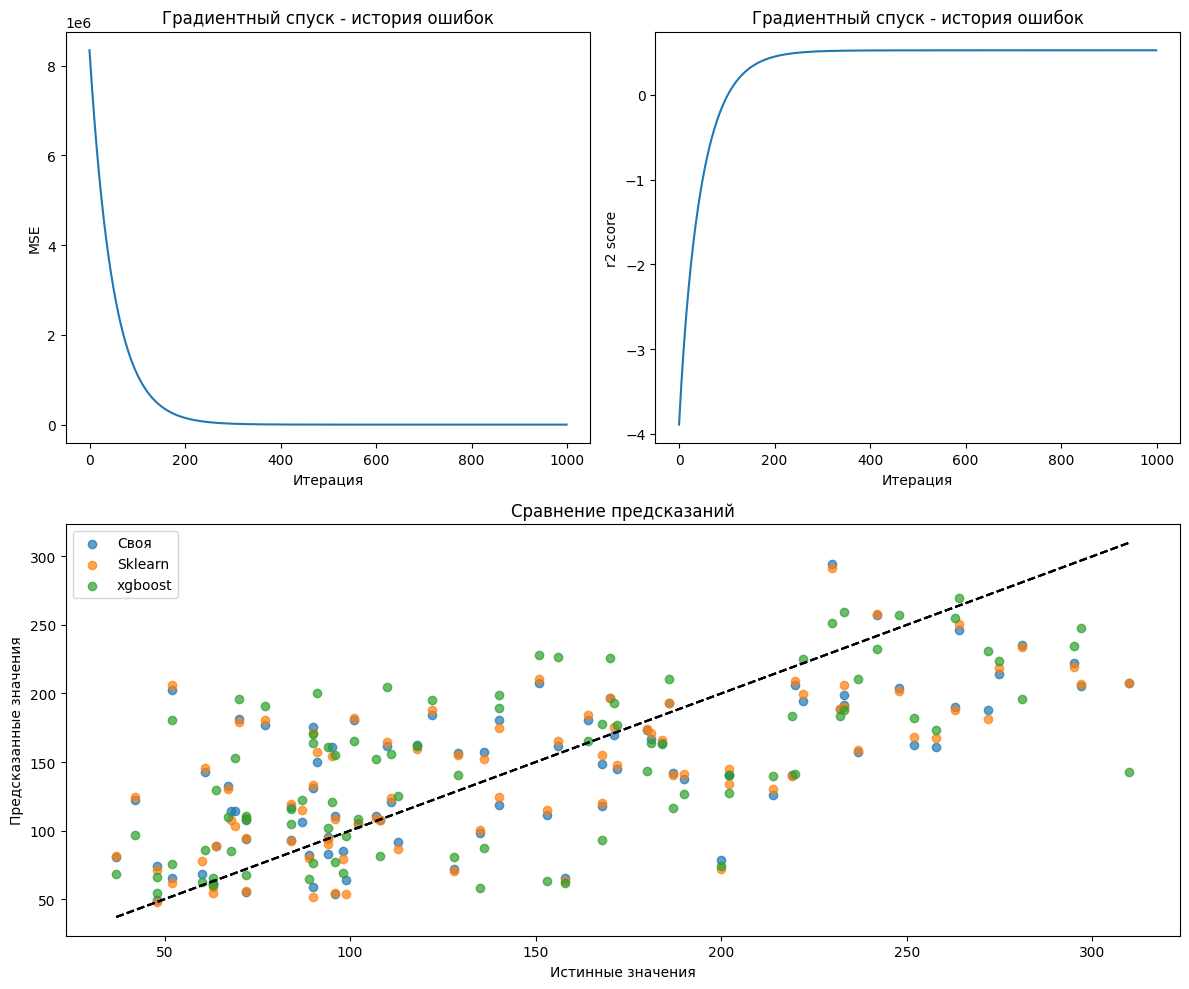

In [95]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)

axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, :])]

for idx_y, (metric_name, ax) in enumerate(zip(reg_metrics_name_list, axes)):
    ax.plot(reg_models[metric_name]["Своя"].metric_history)
    ax.set_title("Градиентный спуск - история ошибок")
    ax.set_xlabel("Итерация")
    ax.set_ylabel(metric_name)
    
for preds, label in zip([reg_predictions, reg_sk_predictions, reg_sk_log_predictions], reg_models_names):
    axes[-1].scatter(y_reg_test, preds[reg_metrics_name_list[0]], alpha=0.7, label=label)
    axes[-1].plot(
        [y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], "k--"
    )
    axes[-1].set_xlabel("Истинные значения")
    axes[-1].set_ylabel("Предсказанные значения")
    axes[-1].legend()
    axes[-1].set_title("Сравнение предсказаний")

plt.tight_layout()
plt.show()